# Importing Libraries

In [1]:
!pip install python-gdcm
!pip install -U pylibjpeg[all]
!pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 42.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.3/969.3 kB 38.9 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import pathlib
import torch
import random
import nibabel as nib
from sklearn.model_selection import StratifiedShuffleSplit
import time
from tqdm import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Setting Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)  
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Helper functions
def show_image(img):
    plt.imshow(img, cmap = 'gray')
    plt.show()
    
def load_image(path, disp_image = False):
    '''
    Arguments:
    path: For loading the dcm data
    disp_image: To display image
    
    Returns:
    img: Numpy array of CT Scans Images
    data: Metadata of CT Scan
    '''
    data = pydicom.dcmread(path)
    img = apply_voi_lut(data.pixel_array, data)
    if disp_image:
        show_image(img)
    img = img - np.min(img)
    if np.max(img) != 0:
        img = img / np.max(img)
    return data, img

In [4]:
# Setting Split Size
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Loading Data

In [5]:
base_path = pathlib.Path('/kaggle/input/rsna-2022-cervical-spine-fracture-detection')
df = pd.read_csv(base_path/'train.csv')
df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [6]:
for column in ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']:
    print(f"{'*'*20}")
    print(df[column].value_counts(normalize = True))
    print(f"{'*'*20}")

********************
0    0.524022
1    0.475978
Name: patient_overall, dtype: float64
********************
********************
0    0.927687
1    0.072313
Name: C1, dtype: float64
********************
********************
0    0.858841
1    0.141159
Name: C2, dtype: float64
********************
********************
0    0.963843
1    0.036157
Name: C3, dtype: float64
********************
********************
0    0.946508
1    0.053492
Name: C4, dtype: float64
********************
********************
0    0.919762
1    0.080238
Name: C5, dtype: float64
********************
********************
0    0.862803
1    0.137197
Name: C6, dtype: float64
********************
********************
0    0.805349
1    0.194651
Name: C7, dtype: float64
********************


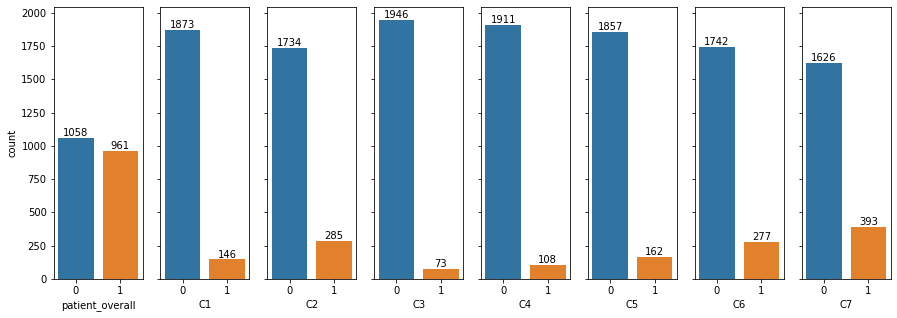

In [7]:
fracture_types = ['patient_overall','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 5), sharey = True)
for idx, fracture in enumerate(fracture_types):
    ax1 = sns.countplot(ax = axes[idx], x = fracture, data = df)
    if idx > 0:
        ax1.set(ylabel = None)
    for container in ax1.containers:
        ax1.bar_label(container)

In [8]:
df['path'] = list(map(lambda x: base_path/'train_images'/x, df['StudyInstanceUID']))
df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,path
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...


In [9]:
# Checking if an instance ID is repeated
print(len(df))
print(len(df['StudyInstanceUID'].unique()))

2019
2019


In [10]:
strat = StratifiedShuffleSplit(n_splits=2, test_size = test_size, 
                                random_state=seed)
for i, (train_val_idx, test_idx) in enumerate(strat.split(df.index, df['C3'])):
    train_val_data = df.iloc[train_val_idx]
    test_data = df.iloc[test_idx]
    
strat = StratifiedShuffleSplit(n_splits=2, test_size = val_size/(train_size + val_size), 
                                random_state=seed)
for (train_idx, valid_idx) in strat.split(train_val_data.index, train_val_data['C3']):
    valid_data = train_val_data.iloc[valid_idx]
    train_data = train_val_data.iloc[train_idx]

In [11]:
idx = 0
path = train_data['path'].iloc[idx]
img_path = list(path.glob("*"))
data,img = load_image(img_path[0])

In [12]:
patient_position = []
for i in img_path:
    data,img = load_image(i)
    position = data[list(data.keys())[9]].value
    patient_position.append(position)

In [13]:
patient_position = np.array(patient_position)

In [14]:
patient_position.std(axis = 0)

array([ 0.        ,  0.        , 63.62389488])

# Segmenataion Mask Analysis

In [15]:
segmentation_files = list((base_path/'segmentations').glob("*"))
len(segmentation_files)

87

In [16]:
segmentation_instanceUID = list(map(lambda x: x.stem, segmentation_files))
segmentation_instanceUID[:3]

['1.2.826.0.1.3680043.780',
 '1.2.826.0.1.3680043.21321',
 '1.2.826.0.1.3680043.6125']

In [17]:
segmentation_df = df[df['StudyInstanceUID'].isin(segmentation_instanceUID)]
segmentation_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,path
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
41,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
53,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
60,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,/kaggle/input/rsna-2022-cervical-spine-fractur...
99,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,/kaggle/input/rsna-2022-cervical-spine-fractur...


In [18]:
len(segmentation_df)

87

In [19]:
idx = 0
file_name = segmentation_df.iloc[idx]
file_name['StudyInstanceUID']

'1.2.826.0.1.3680043.1363'

In [52]:
seg_file_path = f"/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/{file_name['StudyInstanceUID']}.nii"
seg_mask = nib.load(seg_file_path)

# Convert to numpy array
seg = seg_mask.get_fdata()

# Converting the saggital plane of segmentation mask to axial plane to orient with data
seg = seg[:,::-1,::-1].transpose(2,1,0)
seg.shape

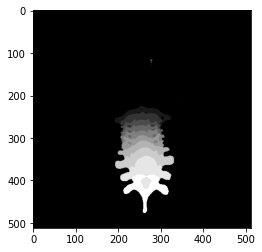

In [51]:
segmen_mean = np.max(seg, axis = 0)
plt.imshow(segmen_mean, cmap = 'gray')

In [114]:
# Find appropriate no of slices to be taken for C1-C7 Vertebrae

no_of_slices = {}
for idx in tqdm(range(len(segmentation_df))):
    file_name = segmentation_df.iloc[idx]
    img_name = file_name['StudyInstanceUID']
    seg_file_path = f"/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/{img_name}.nii"
    seg_mask = nib.load(seg_file_path)

    # Convert to numpy array
    seg = seg_mask.get_fdata()

    # Converting the saggital plane of segmentation mask to axial plane to orient with data
    seg = seg[:,::-1,::-1].transpose(2,1,0)
    
    count = 0
    for i in range(len(seg)):
        mask_labels = np.unique(seg[i])
        # Check whether the mask contain value between 0 and 7
        if np.any(mask_labels == 7):
            count = i
        else:
            continue
    
    no_of_slices[img_name] = count

100%|██████████| 87/87 [04:34<00:00,  3.16s/it]


In [115]:
count_df = pd.DataFrame(list(no_of_slices.items()), columns = ['StudyInstanceUID', 'Slice Count'])
count_df.head()

,StudyInstanceUID,Slice Count
0,1.2.826.0.1.3680043.1363,165
1,1.2.826.0.1.3680043.25704,236
2,1.2.826.0.1.3680043.20647,224
3,1.2.826.0.1.3680043.31077,424
4,1.2.826.0.1.3680043.17960,192


In [116]:
count_df.describe()

,Slice Count
count,87.000000
mean,273.057471
std,90.878062
min,142.000000
25%,204.500000
50%,248.000000
75%,326.500000
max,528.000000


In [117]:
count_df['path'] = list(map(lambda x: base_path/'train_images'/x, count_df['StudyInstanceUID']))
count_df.head()

,StudyInstanceUID,Slice Count,path
0,1.2.826.0.1.3680043.1363,165,/kaggle/input/rsna-2022-cervical-spine-fractur...
1,1.2.826.0.1.3680043.25704,236,/kaggle/input/rsna-2022-cervical-spine-fractur...
2,1.2.826.0.1.3680043.20647,224,/kaggle/input/rsna-2022-cervical-spine-fractur...
3,1.2.826.0.1.3680043.31077,424,/kaggle/input/rsna-2022-cervical-spine-fractur...
4,1.2.826.0.1.3680043.17960,192,/kaggle/input/rsna-2022-cervical-spine-fractur...


    patient_overall  C1  C2  C3  C4  C5  C6  C7
41                0   0   0   0   0   0   0   0


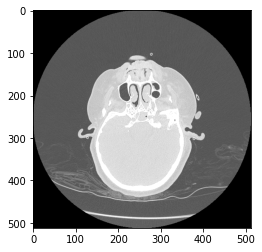

In [122]:
idx = 1
path = count_df['path'].iloc[idx]
instance_id = count_df['StudyInstanceUID']
img_path = list(path.glob("*"))
labels = df[df['path'] == path][['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
print(labels)
data,img = load_image(img_path[2], disp_image = True)

In [123]:
data

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.25704.1.12
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.25704.1.12
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '181009.800582'
(0010, 0010) Patient's Name                      PN: '25704'
(0010, 0020) Patient ID                          LO: '25704'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0

In [121]:
data

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.17960.1.12
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.17960.1.12
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182342.764771'
(0010, 0010) Patient's Name                      PN: '17960'
(0010, 0020) Patient ID                          LO: '17960'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0

In [119]:
data

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.31077.1.240
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.31077.1.240
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182255.515926'
(0010, 0010) Patient's Name                      PN: '31077'
(0010, 0020) Patient ID                          LO: '31077'
(0018, 0050) Slice Thickness                     DS: '0.6'